In [ ]:
import numpy as np

import torch

import torch.nn as nn

import matplotlib.pyplot as plt

import torch.nn.functional as F

import math

from wfcQUBOfunctions import genLegalQ, seedMap, genGlobalProbQ,oneHotQ, qubo

from miscFunctions import *


In [ ]:
# Old?

if 0:

    num_tiles = 44
    H = 10
    W = 10

    p = num_tiles

    c = np.arange(p)
    v_ = torch.zeros(H+2,W+2)
    K_ = torch.zeros(num_tiles, num_tiles)

    v_ = np.random.randint(0,num_tiles, size=(H+2,W+2))

    disp = [[-1,-1],  [0, -1], [1,-1],
            [-1, 0],           [1, 0],
            [-1, 1],  [0,  1], [1, 1]]

    for i in range(1,W):
        for j in range(1,H):
            x = v_[i,j]
            for d in disp:
                y = v_[i+d[0], j+d[1]]
                K_[int(x),int(y)] = 1
                K_[int(y),int(x)] = 1


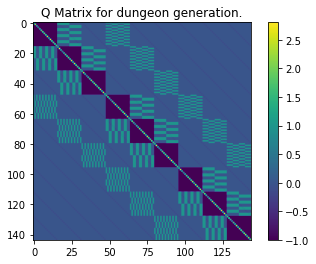

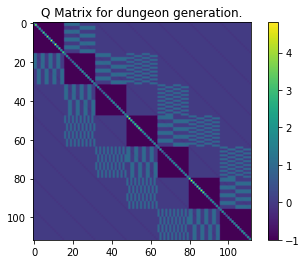

In [ ]:

# Note: an 8x8 map with 16 tile choices requires 1024 qubits.
# 1024 bits are 0.128 kilobytes

num_tiles = 16
H = 3
W = 3
mapSize = H*W

# Side 0 connects to side 2 etc...
links = [[0,2], # Left
         [1,3], # Bot
         [2,0], # Right
         [3,1]] # Top

# Using cartesian i,j coordiante system
ofs = [[-1, 0], # Left
       [0,  -1], # Down
       [1,  0], # Right
       [0, 1]] # Up

direction = ["Left",
             "Down",
             "Right",
             "Up"] 

key = genDungeonKey(links, num_tiles)

P_vec = np.random.random(num_tiles)
#P_vec[0] += 1
#P_vec = P_vec / np.sum(P_vec)
Q = np.zeros((num_tiles*mapSize,num_tiles*mapSize))

Q_ = [genLegalQ(num_tiles, ofs, key, H, W), 
      oneHotQ(num_tiles, H, W, 1 ),
      genGlobalProbQ(num_tiles, H, W, P_vec)/ (H*W)] 

Q = np.zeros_like(Q_[0])
for q in Q_:
    Q += q

num_seeds = 2
preset1 = 5
preset2 = 13
i1 = 0
j1 = 1
idc1 = (i1 + j1*W) * num_tiles 
i2 = 0
j2 = 2
idc2 = (i2 + j2*W) * num_tiles 

seed = np.zeros((num_seeds, num_tiles)) 
seed[0][preset1] = 1 
seed[1][preset2] = 1 

Q_s = seedMap(Q_, seed, [idc1,idc2])     

if 0:
    ids = [[0,4,8,12,16,20,24, 28],
        [1,5,9,13,17,21,25,29],
        [2,6,10,14,18,22,26,30],
        [3,7,11,15]]
    trial_vec = np.zeros((num_tiles*W*H))

    trial_vec[ids[0][:4]] = 1 # Max energy of 4
    print(qubo(trial_vec, Q))
    trial_vec[ids[1][4:6]] = 1 # Max energy of 4
    print(qubo(trial_vec, Q))
    trial_vec[ids[2][5:7]] = 1
    #trial_vec[ids[3][:2]] = 1

    op = qubo(trial_vec, Q)

    tv = np.zeros(H*W*num_tiles)
    for i in range(H*W*num_tiles):
        if trial_vec[i] > 0:
            tv[i] = (i)%4+1

    print(op)
    print(":",tv) 
    # 9.6190

if 1:
    plt.figure(1)
    plt.title("Q Matrix for dungeon generation.")
    plt.imshow(Q) 
    plt.colorbar()

    plt.figure(3)
    plt.title("Q Matrix for dungeon generation.")
    plt.imshow(Q_s) #[:num_tiles, :num_tiles]) 
    plt.colorbar()

if 0:

    for ii in range(W):
        i = ii*num_tiles
        ctr = ii*num_tiles

        for jj in range(H):
            j = jj*num_tiles

            if jj != ii:
                for itr in range(len(ofs)):
                    o = ofs[itr]
                    k = key[itr]

                    i_s = i+num_tiles*o[0] + ctr
                    j_s = j+num_tiles*o[1] + ctr

                    if i_s >= 0 and j_s >= 0 and i_s < W*num_tiles and j_s < H*num_tiles:
                        q = Q[i_s:i_s+num_tiles,j_s:j_s+num_tiles]
                        Q[i_s:i_s+num_tiles,j_s:j_s+num_tiles] += k
                        
                        
                        


    plt.imshow(Q)
    plt.xlim([0,num_tiles*mapSize])
    plt.ylim([0,num_tiles*mapSize])
    plt.colorbar()


[0.052446461662009024, 0.01941852355441415, 0.025449609555941468, 0.11390043538688698, 0.10168966970335779, 0.03027972419641973, 0.06751042049520445, 0.06320736461450575, 0.02746495123926864, 0.0672582272421845, 0.10415131154144136, 0.001938590364816837, 0.09178498159504787, 0.1235142501615559, 0.09037508035743597, 0.01961039832950958]


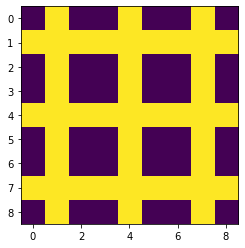

In [114]:

check = [[0,1],
         [1,0],
         [2,1],
         [1,2]]

t_im = []
tile_pallet = np.zeros((3*4,3*4))
tiles = []

for i in range(num_tiles):
    tiles.append(decomp(i)[4:])

for t_ in tiles:
    t = np.zeros((3,3))
    for ctr in range(len(t_)):
        if t_[ctr]:
            t[check[ctr][0]][check[ctr][1]] = 1
    
    if np.sum(t[:][:]) > 0:
        t[1][1] = 1

    t_im.append(t)

for ctr in range(len(t_im)):
    icr = ctr*3
    ici = icr%12
    icj = (icr//12)*3
    tile_pallet[ici:ici+3,icj:icj+3] += t_im[ctr]


mw = W #8
mh = H #8
intMap = np.zeros((mw,mh))
im = np.zeros((mw*3, mh*3))

for i in range(mw):
    for j in range(mh):
        intMap[i][j] = np.random.randint(0,num_tiles)

for i in range(mw):
    ii = int(i*3)

    for j in range(mh):
        jj = int(j*3)
        val = intMap[i][j]
        im[ii:ii+3, jj:jj+3] = t_im[int(val)]

mx = -np.inf
best_vec = []
ids = np.arange(16)
rng = np.random.default_rng()

pp = []
for itr in range(len(P_vec)):
    p = P_vec[itr] 
    pp.append(p)


print(pp)
for _ in range(10):
    vecR = np.random.randint(0, num_tiles, mh*mw)
    #vecR = rng.choice(16, 64,p=pp) 
    vec = np.zeros((num_tiles*mh*mw,1))

    for ctr in range(len(vecR)):
        v = vecR[ctr]
        v = 15
        #v = 10 #5 #15 5 #
        icr = ctr*16
        vec[icr+v] = 1
    
    energy = qubo(vec, Q)

    if energy > mx:
        mx = energy
        best_vec = vec

im = vec2im(best_vec, num_tiles, H, W, t_im)
plt.figure(1)
plt.imshow(im)


In [6]:





for i in range(24):
    print(i, ":", i*i*16)





0 : 0
1 : 16
2 : 64
3 : 144
4 : 256
5 : 400
6 : 576
7 : 784
8 : 1024
9 : 1296
10 : 1600
11 : 1936
12 : 2304
13 : 2704
14 : 3136
15 : 3600
16 : 4096
17 : 4624
18 : 5184
19 : 5776
20 : 6400
21 : 7056
22 : 7744
23 : 8464


In [ ]:

if 0:
    totall = 30
    sigma = 0.33 

    pen = 0.12375/30
    reward = pen #sigma
    penalty = -(pen)

    print(reward, penalty)

    r = []
    mx = 0


    N = 100
    P = 0.25
    n = 25


    for i in range(totall):
        num= i
        r.append(num*reward*P + P*num*(P*num-1)*penalty)
        if r[-1] >= mx:
            mx = r[-1]
            print(i+1)

In [ ]:

# Flavor text otpimzation functions

def genIDF(num_tiles, H, W, docSize, encPer):

    
    # Assume swaure map H = W
    factor = H % docSize
    if factor != 0:
        pad = docSize - factor
    
    
    # Assume for now docSize fits into map size

    d = ( H // docSize )**2 # Number of "documents" in map decomposition
    
    q_idf = d * num_tiles # Tells us if a given tile is active anywhere within a document
    q_tf  = d * num_tiles * len(encPer) # Tells us what percentage of likelihood a given tile has within a document
    


    print(q_idf, q_tf)




    #  TF-IDF = internal_doc_freq * log(global_occ_ratio)

    #  TF is affected locally and globally 

    #  A*(q1q2+q1q3 +  q2q1+q2q3 + q3q1+q3q2) + B(q1q7+q1q8+q1q9 + q2q7+q2q8+q2q9 + q3q7+q3q8+q3q9)

    #  ( A1*(nn)+B1*(n'n') ) + 
    #  ( A2*(n*n-1) + B2(n'*n'-1) ) + 
    #  ( B12*(n*n') ) 
    #   = IDF  



    # IDF = log10(N/n)
    # TF  = m/K




100 500
0.984375


In [ ]:
    

reward = 0.5
penalty = -reward
num = 5
print(num*reward - num*(num-2)*penalty)

# 1, 1+1 - (1), 1+1+1 - (1+1 + 1+1 + 1+1), 

# Probability occurance 


p_vec = np.random.random(2)
p_vec = p_vec / np.sum(p_vec)
p_vec = np.zeros(2)
p_vec[:] = 0.5
print(p_vec)

plt.imshow(genGlobalProbQ(2, 2, 2, p_vec))
plt.colorbar()


# Cross correlation influence

random_map = np.random.randint(0,16,(100,100))

gpv = np.random.randint(0,100,num_tiles)
gpv = gpv/np.sum(gpv)










In [ ]:


# DWAVE SHIT

endpoint = "https://cloud.dwavesys.com/sapi"
token = "my_token"
url = 0


In [ ]:

# Genetic algorithm


import random 

def initialize_population(size, num_genes):
    return np.random.randint(2, size=(size, num_genes))

def fitness(individual, Q):
    return qubo(individual, Q)

def select_parents(population, fitness_values):
    fitness_values = fitness_values - np.min(fitness_values)
    total_fitness = sum(fitness_values)
    selection_probs = [f / total_fitness for f in fitness_values]
   
    parents_indices = np.random.choice(len(population), size=2, p=selection_probs)

    return population[parents_indices[0]], population[parents_indices[1]]

def crossover(parent1, parent2):
    crossover_point = random.randint(0, len(parent1)-1)
    child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
    child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
    return child1, child2

def mutate(individual, mutation_rate):
    for i in range(len(individual)):
        if random.random() < mutation_rate:
            individual[i] = 1 - individual[i]
    return individual


population_size = 100
num_generations = 1000
mutation_rate = 0.05

mx = 0
num_genes = num_tiles*H*W
population = initialize_population(population_size, num_genes)

for generation in range(num_generations):
    fitness_values = [fitness(ind, Q) for ind in population] 
    new_population = []

    if generation%50 == 0:
        print(np.max(fitness_values))
        if np.max(fitness_values) > mx:
            mx = np.max(fitness_values)

    for _ in range(population_size // 2):
        parent1, parent2 = select_parents(population, fitness_values)
        child1, child2 = crossover(parent1, parent2)
        child1 = mutate(child1, mutation_rate)
        child2 = mutate(child2, mutation_rate)
        new_population.extend([child1, child2])

    population = np.array(new_population)

  



